In [11]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

In [24]:
class CFE():
    def __init__(self, cfg_file=None):
        super(CFE, self).__init__()
        
        self.cfg_file = cfg_file
       
        ############################################################
        # ________________________________________________________ #
        # ________________________________________________________ #
        # GET VALUES FROM CONFIGURATION FILE.                      #
                                                                   #
        self.config_from_json()                                    #
                                                                   #
        # GET VALUES FROM CONFIGURATION FILE.                      #
        # ________________________________________________________ #
        # ________________________________________________________ #
        ############################################################        

        # ________________________________________________
        # In order to check mass conservation at any time
        self.reset_volume_tracking()
        
        # ________________________________________________
        # initialize simulation constants
        atm_press_Pa=101325.0
        unit_weight_water_N_per_m3=9810.0
        
        # ________________________________________________
        # Time control
        self.time_step_size = 3600
        self.timestep_h = self.time_step_size / 3600.0
        self.timestep_d = self.timestep_h / 24.0
        self.current_time_step = 0
        self.current_time = pd.Timestamp(year=1970, month=1, day=1, hour=0)
        
        # ________________________________________________
        # Inputs
        self.timestep_rainfall_input_m = 0
        self.potential_et_m_per_s      = 0
        
        # ________________________________________________
        # calculated flux variables
        self.flux_overland_m                = 0 # surface runoff that goes through the GIUH convolution process
        self.flux_perc_m                    = 0 # flux from soil to deeper groundwater reservoir
        self.flux_lat_m                     = 0 # lateral flux in the subsurface to the Nash cascade
        self.flux_from_deep_gw_to_chan_m    = 0 # flux from the deep reservoir into the channels
        self.gw_reservoir_storage_deficit_m = 0 # the available space in the conceptual groundwater reservoir
        self.primary_flux                   = 0 # temporary vars.
        self.secondary_flux                 = 0 # temporary vars.
        self.total_discharge                = 0
        
        # ________________________________________________
        # Evapotranspiration
        self.potential_et_m_per_timestep = 0
        self.actual_et_m_per_timestep    = 0
        
         
        # ________________________________________________________
        # Set these values now that we have the information from the configuration file.
        self.runoff_queue_m_per_timestep = np.zeros(len(self.giuh_ordinates)+1) #@@@ padded a zero add the end @@@
        self.num_giuh_ordinates = len(self.giuh_ordinates) #@@@@ changed to GIUH @@@@
        self.num_lateral_flow_nash_reservoirs = len(self.nash_storage)
        
        # ________________________________________________
        # Local values to be used in setting up soil reservoir
        trigger_z_m = 0.5
        
        field_capacity_atm_press_fraction = 0.33
        
        H_water_table_m=field_capacity_atm_press_fraction * atm_press_Pa / unit_weight_water_N_per_m3 
        
        soil_water_content_at_field_capacity = self.soil_params['smcmax'] * \
                                     np.power(H_water_table_m/self.soil_params['satpsi'],(1.0/self.soil_params['bb']))
        
        Omega     = H_water_table_m - trigger_z_m
        
        lower_lim = np.power(Omega , (1.0-1.0/self.soil_params['bb']))/(1.0-1.0/self.soil_params['bb']);
        
        upper_lim = np.power(Omega+self.soil_params['D'],(1.0-1.0/self.soil_params['bb']))/(1.0-1.0/self.soil_params['bb'])

        storage_thresh_pow_term = np.power(1.0/self.soil_params['satpsi'],(-1.0/self.soil_params['bb']))

        lim_diff = (upper_lim-lower_lim)

        field_capacity_power = np.power(1.0/self.soil_params['satpsi'],(-1.0/self.soil_params['bb']))

        field_capacity_storage_threshold_m = self.soil_params['smcmax'] * field_capacity_power * lim_diff
        
        
        # ________________________________________________
        # lateral flow function parameters
        assumed_near_channel_water_table_slope = 0.01 # [L/L]
        lateral_flow_threshold_storage_m       = field_capacity_storage_threshold_m
#         lateral_flow_linear_reservoir_constant = 2.0 * assumed_near_channel_water_table_slope * \     # Not used
#                                                  self.soil_params['mult'] * NWM_soil_params.satdk * \ # Not used
#                                                  self.soil_params['D'] * drainage_density_km_per_km2  # Not used
#         lateral_flow_linear_reservoir_constant *= 3600.0                                              # Not used
        self.soil_reservoir_storage_deficit_m  = 0

        # ________________________________________________
        # Subsurface reservoirs
        self.gw_reservoir = {'is_exponential':True,
                              'storage_max_m':1.0,
                              'coeff_primary':0.01,
                              'exponent_primary':6.0,
                              'storage_threshold_primary_m':0.0,
                              'storage_threshold_secondary_m':0.0,
                              'coeff_secondary':0.0,
                              'exponent_secondary':1.0}
        self.gw_reservoir['storage_m'] = self.gw_reservoir['storage_max_m'] * 0.01
        self.volstart                 += self.gw_reservoir['storage_m']
        self.vol_in_gw_start           = self.gw_reservoir['storage_m']

        self.soil_reservoir = {'is_exponential':False,
                               'storage_max_m':self.soil_params['smcmax'] * self.soil_params['D'],
                               'coeff_primary':self.soil_params['satdk'] * self.soil_params['slop'] * 3600.0,
                               'exponent_primary':1.0,
                               'storage_threshold_primary_m':self.soil_params['smcmax'] * storage_thresh_pow_term*
                                                             (upper_lim-lower_lim),
                               'coeff_secondary':0.01,
                               'exponent_secondary':1.0,
                               'storage_threshold_secondary_m':lateral_flow_threshold_storage_m}
        self.soil_reservoir['storage_m'] = self.soil_reservoir['storage_max_m'] * 0.667
        self.volstart                   += self.soil_reservoir['storage_m']
        self.vol_soil_start              = self.soil_reservoir['storage_m']
        
        
        # ________________________________________________
        # Schaake
        self.refkdt = 3.0
        self.Schaake_adjusted_magic_constant_by_soil_type = self.refkdt * self.soil_params['satdk'] / 2.0e-06
        self.Schaake_output_runoff_m = 0
        self.infiltration_depth_m = 0
        
        
        # ________________________________________________
        # Nash cascade        
        self.K_nash = 0.03        
        
    # __________________________________________________________________________________________________________
    # MAIN MODEL FUNCTION
    def run_cfe(self):
        
        # ________________________________________________
        self.volin += self.timestep_rainfall_input_m
        
        # ________________________________________________
        self.potential_et_m_per_timestep = self.potential_et_m_per_s * self.time_step_size
        
        # ________________________________________________
        # timestep_rainfall_input_m = f(timestep_rainfall_input_m, potential_et_m_per_timestep)
        self.et_from_rainfall()
        
        # ________________________________________________        
        self.soil_reservoir_storage_deficit_m = (self.soil_params['smcmax'] * \
                                                 self.soil_params['D'] - \
                                                 self.soil_reservoir['storage_m'])
        
        # ________________________________________________
        # Calculates the value for surface_runoff_depth_m
        self.Schaake_partitioning_scheme()

        # ________________________________________________
        self.et_from_soil()
        
        # ________________________________________________
        if self.soil_reservoir_storage_deficit_m < self.infiltration_depth_m:
            # put won't fit back into runoff
            self.surface_runoff_depth_m += (self.infiltration_depth_m - soil_reservoir_storage_deficit_m)
            self.infiltration_depth_m = self.soil_reservoir_storage_deficit_m
            self.soil_reservoir['storage_m'] = self.soil_reservoir['storage_max_m']

        # ________________________________________________
        self.vol_sch_runoff += self.surface_runoff_depth_m
        self.vol_sch_infilt += self.infiltration_depth_m

        # ________________________________________________ @@@ new @@@
        if self.current_time_step == 0:
            self.previous_flux_perc_m = self.flux_perc_m
            
        # ________________________________________________
        if self.previous_flux_perc_m > self.soil_reservoir_storage_deficit_m:
            diff = self.previous_flux_perc_m - self.soil_reservoir_storage_deficit
            self.infiltration_depth_m = self.soil_reservoir_storage_deficit_m
            self.vol_sch_runoff += diff
            self.vol_sch_infilt -= diff # correct overprediction of infilt. @@@ edit @@@
            self.surface_runoff_depth_m += diff
            
        # ________________________________________________
        self.vol_to_soil += self.infiltration_depth_m
        self.soil_reservoir['storage_m'] += self.infiltration_depth_m

        # ________________________________________________
        # primary_flux, secondary_flux = f(reservoir)
        self.conceptual_reservoir_flux_calc(self.soil_reservoir)

        # ________________________________________________
        self.flux_perc_m = self.primary_flux
        self.flux_lat_m = self.secondary_flux

        # ________________________________________________
        self.gw_reservoir_storage_deficit_m = self.gw_reservoir['storage_max_m'] - self.gw_reservoir['storage_m']
        
        # ________________________________________________
        if self.flux_perc_m > self.gw_reservoir_storage_deficit_m:
            diff = self.flux_perc_m - self.gw_reservoir_storage_deficit_m
            self.flux_perc_m = self.gw_reservoir_storage_deficit_m
            self.vol_sch_runoff+=diff 
            self.vol_sch_infilt-=diff 
            
        # ________________________________________________
        self.vol_to_gw                += self.flux_perc_m
        self.vol_soil_to_gw           += self.flux_perc_m

        self.gw_reservoir['storage_m']   += self.flux_perc_m
        self.soil_reservoir['storage_m'] -= self.flux_perc_m
        self.soil_reservoir['storage_m'] -= self.flux_lat_m
        self.vol_soil_to_lat_flow        += self.flux_lat_m  #TODO add this to nash cascade as input
        self.volout                       = self.volout + self.flux_lat_m;

            
        # ________________________________________________
        # primary_flux, secondary_flux = f(reservoir)
        self.conceptual_reservoir_flux_calc( self.gw_reservoir )
            
        # ________________________________________________
        self.flux_from_deep_gw_to_chan_m = self.primary_flux
        self.vol_from_gw += self.flux_from_deep_gw_to_chan_m
        
        # ________________________________________________        
        if not self.is_fabs_less_than_epsilon(self.secondary_flux, 1.0e-09):
            print("problem with nonzero flux point 1\n")
                        
        # ________________________________________________                               
        self.gw_reservoir['storage_m'] -= self.flux_from_deep_gw_to_chan_m
        
        # ________________________________________________
        # giuh_runoff_m = f(Schaake_output, giuh_ordinates, runoff_queue_m_per_timestep)
        self.convolution_integral()
        
        # ________________________________________________
        self.vol_out_giuh += self.flux_giuh_runoff_m
        self.volout += self.flux_giuh_runoff_m
        self.volout += self.flux_from_deep_gw_to_chan_m
        
        # ________________________________________________
        self.nash_cascade()

        # ________________________________________________
        self.vol_in_nash += self.flux_lat_m
        self.vol_out_nash += self.flux_nash_lateral_runoff_m
        
        # ________________________________________________
        self.flux_Qout_m = self.flux_giuh_runoff_m + self.flux_nash_lateral_runoff_m + self.flux_from_deep_gw_to_chan_m
        self.total_discharge = self.flux_Qout_m * self.catchment_area_km2 * 1000000.0 / 3600.0
        
        # ________________________________________________
        self.current_time_step += 1
        self.current_time      += pd.Timedelta(value=self.time_step_size, unit='s')

        return
    
    
    # __________________________________________________________________________________________________________
    def nash_cascade(self):
        """
            Solve for the flow through the Nash cascade to delay the 
            arrival of the lateral flow into the channel
        """
        Q = np.zeros(self.num_lateral_flow_nash_reservoirs)
        
        for i in range(self.num_lateral_flow_nash_reservoirs):
            
            Q[i] = self.K_nash * self.nash_storage[i]
            
            self.nash_storage[i] -= Q[i]
            
            if i == 0:
                
                self.nash_storage[i] += self.flux_lat_m
                
            else:
                
                self.nash_storage[i] += Q[i-1]
        
        self.flux_nash_lateral_runoff_m = Q[self.num_lateral_flow_nash_reservoirs - 1]
        
        return
    
                               
    # __________________________________________________________________________________________________________ @@@ changed @@@
    def convolution_integral(self): 
        """
            This function solves the convolution integral involving N
            GIUH ordinates.
        """
        #print('self.runoff_queue_m_per_timestep', self.runoff_queue_m_per_timestep)
        #print('self.giuh_ordinates', self.giuh_ordinates)
        #print('self.surface_runoff_depth_m', self.surface_runoff_depth_m)
        #print('self.flux_giuh_runoff_m', self.flux_giuh_runoff_m)
        #breakpoint()
        for i in range(self.num_giuh_ordinates): 
        
            self.runoff_queue_m_per_timestep[i] += self.giuh_ordinates[i] * self.surface_runoff_depth_m
            
        self.flux_giuh_runoff_m = self.runoff_queue_m_per_timestep[0]
        
        #print('self.runoff_queue_m_per_timestep', self.runoff_queue_m_per_timestep)
        #print('self.giuh_ordinates', self.giuh_ordinates)
        #print('self.surface_runoff_depth_m', self.surface_runoff_depth_m)
        #print('self.flux_giuh_runoff_m', self.flux_giuh_runoff_m)
        #breakpoint()
        for i in range(self.num_giuh_ordinates):  # shift all the entries in preperation ffor the next timestep
            
            self.runoff_queue_m_per_timestep[i] = self.runoff_queue_m_per_timestep[i+1]
        
        #print('self.runoff_queue_m_per_timestep', self.runoff_queue_m_per_timestep)
        #print('self.giuh_ordinates', self.giuh_ordinates)
        #print('self.surface_runoff_depth_m', self.surface_runoff_depth_m)
        #print('self.flux_giuh_runoff_m', self.flux_giuh_runoff_m)    
        #breakpoint()
        return
    
    
    # __________________________________________________________________________________________________________
    def et_from_rainfall(self):
        
        """
            iff it is raining, take PET from rainfall first.  Wet veg. is efficient evaporator.
        """
        
        if self.timestep_rainfall_input_m >0.0:

            if self.timestep_rainfall_input_m > self.potential_et_m_per_timestep:
        
                self.actual_et_m_per_timestep = self.potential_et_m_per_timestep
                self.timestep_rainfall_input_m -= self.actual_et_m_per_timestep

            else: 

                self.potential_et_m_per_timestep -= self.timestep_rainfall_input_m
                self.timestep_rainfall_input_m=0.0
        return
                
                
    # __________________________________________________________________________________________________________
    ########## SINGLE OUTLET EXPONENTIAL RESERVOIR ###############
    ##########                -or-                 ###############
    ##########    TWO OUTLET NONLINEAR RESERVOIR   ###############                        
    def conceptual_reservoir_flux_calc(self, reservoir):
        """
            This function calculates the flux from a linear, or nonlinear 
            conceptual reservoir with one or two outlets, or from an
            exponential nonlinear conceptual reservoir with only one outlet.
            In the non-exponential instance, each outlet can have its own
            activation storage threshold.  Flow from the second outlet is 
            turned off by setting the discharge coeff. to 0.0.
        """

        if reservoir['is_exponential'] == True: 
            flux_exponential = np.exp(reservoir['exponent_primary'] * \
                                      reservoir['storage_m'] / \
                                      reservoir['storage_max_m']) - 1.0
            self.primary_flux_m = reservoir['coeff_primary'] * flux_exponential
            self.secondary_flux_m=0.0
            return
    
        self.primary_flux_m=0.0
        
        storage_above_threshold_m = reservoir['storage_m'] - reservoir['storage_threshold_primary_m']
        
        if storage_above_threshold_m > 0.0:
                               
            storage_diff = reservoir['storage_max_m'] - reservoir['storage_threshold_primary_m']
            storage_ratio = storage_above_threshold_m / storage_diff
            storage_power = np.power(storage_ratio, reservoir['exponent_primary'])
            
            self.primary_flux_m = reservoir['coeff_primary'] * storage_power

            if self.primary_flux_m > storage_above_threshold_m:
                self.primary_flux_m = storage_above_threshold_m
                
        self.secondary_flux_m = 0.0;
            
        storage_above_threshold_m = reservoir['storage_m'] - reservoir['storage_threshold_secondary_m']
        
        if storage_above_threshold_m > 0.0:
            
            storage_diff = reservoir['storage_max_m'] - reservoir['storage_threshold_secondary_m']
            storage_ratio = storage_above_threshold_m / storage_diff
            storage_power = np.power(storage_ratio, reservoir['exponent_secondary'])
            
            self.secondary_flux_m = reservoir['coeff_secondary'] * storage_power
            
            if self.secondary_flux_m > (storage_above_threshold_m - self.primary_flux_m):
                self.secondary_flux_m = storage_above_threshold_m - self.primary_flux_m
                
        return
    
    
    # __________________________________________________________________________________________________________
    #  SCHAAKE RUNOFF PARTITIONING SCHEME
    def Schaake_partitioning_scheme(self):
        """
            This subtroutine takes water_input_depth_m and partitions it into surface_runoff_depth_m and
            infiltration_depth_m using the scheme from Schaake et al. 1996. 
            !--------------------------------------------------------------------------------
            modified by FLO April 2020 to eliminate reference to ice processes, 
            and to de-obfuscate and use descriptive and dimensionally consistent variable names.
            
            inputs:
              timestep_d
              Schaake_adjusted_magic_constant_by_soil_type = C*Ks(soiltype)/Ks_ref, where C=3, and Ks_ref=2.0E-06 m/s
              column_total_soil_moisture_deficit_m (soil_reservoir_storage_deficit_m)
              water_input_depth_m (timestep_rainfall_input_m) amount of water input to soil surface this time step [m]
            outputs:
              surface_runoff_depth_m      amount of water partitioned to surface water this time step [m]
              infiltration_depth_m
        """
        
        if 0 < self.timestep_rainfall_input_m:
            
            if 0 > self.soil_reservoir_storage_deficit_m:
                
                self.surface_runoff_depth_m = self.timestep_rainfall_input_m
                
                self.infiltration_depth_m = 0.0
                
            else:
                
                schaake_exp_term = np.exp(- self.Schaake_adjusted_magic_constant_by_soil_type * self.timestep_d) 
                
                Schaake_parenthetical_term = (1.0 - schaake_exp_term)
                
                Ic = self.soil_reservoir_storage_deficit_m * Schaake_parenthetical_term
                
                Px = self.timestep_rainfall_input_m
                
                self.infiltration_depth_m = (Px * (Ic / (Px + Ic)))
                
                if 0.0 < (self.timestep_rainfall_input_m - self.infiltration_depth_m):
                    
                    self.surface_runoff_depth_m = self.timestep_rainfall_input_m - self.infiltration_depth_m
                    
                else:
                    
                    self.surface_runoff_depth_m = 0.0
                    
                    self.infiltration_depth_m =  self.timestep_rainfall_input_m - self.surface_runoff_depth_m
                    
        else:
            
            self.surface_runoff_depth_m = 0.0
            
            self.infiltration_depth_m = 0.0
            
        return
            
                               
    # __________________________________________________________________________________________________________
    def et_from_soil(self):
        """
            take AET from soil moisture storage, 
            using Budyko type curve to limit PET if wilting<soilmoist<field_capacity
        """
        
        if self.potential_et_m_per_timestep > 0:
            
            print("this should not happen yet. Still debugging the other functions.")
            
            if self.soil_reservoir['storage_m'] >= self.soil_reservoir['storage_threshold_primary_m']:
            
                self.actual_et_m_per_timestep = np.min(self.potential_et_m_per_timestep, 
                                                       self.soil_reservoir['storage_m'])

                self.soil_reservoir['storage_m'] -= self.actual_et_m_per_timestep

                self.et_struct['potential_et_m_per_timestep'] = 0.0
                               
            elif (self.soil_reservoir['storage_m'] > self.soil_reservoir['wilting_point_m'] and 
                  self.soil_reservoir['storage_m'] < self.soil_reservoir['storage_threshold_primary_m']):
            
                Budyko_numerator = self.soil_reservoir['storage_m'] - self.soil_reservoir['wilting_point_m']
                Budyko_denominator = self.soil_reservoir['storage_threshold_primary_m'] - \
                                     self.soil_reservoir['wilting_point_m']
                Budyki = Budyko_numerator / Budyko_denominator
                               
                self.actual_et_m_per_timestep = Budyko * self.potential_et_m_per_timestep
                               
                self.soil_reservoir['storage_m'] -= self.actual_et_m_per_timestep
        return
            
            
    # __________________________________________________________________________________________________________
    def is_fabs_less_than_epsilon(self,a,epsilon):
        
        if np.abs(a) < epsilon:
            
            return True
        
        else:
            
            return False 
    

    # ________________________________________________
    # Mass balance tracking
    def reset_volume_tracking(self):
        self.volstart             = 0
        self.vol_sch_runoff       = 0
        self.vol_sch_infilt       = 0
        self.vol_out_giuh         = 0
        self.vol_end_giuh         = 0
        self.vol_to_gw            = 0
        self.vol_to_gw_start      = 0
        self.vol_to_gw_end        = 0
        self.vol_from_gw          = 0
        self.vol_in_nash          = 0
        self.vol_in_nash_end      = 0
        self.vol_out_nash         = 0
        self.vol_soil_start       = 0
        self.vol_to_soil          = 0
        self.vol_soil_to_lat_flow = 0
        self.vol_soil_to_gw       = 0
        self.vol_soil_end         = 0
        self.volin                = 0
        self.volout               = 0
        self.volend               = 0
        return
    
    #________________________________________________________
    def config_from_json(self):
        with open(self.cfg_file) as data_file:
            data_loaded = json.load(data_file)

        # ___________________________________________________
        # MANDATORY CONFIGURATIONS
        self.forcing_file               = data_loaded['forcing_file']
        self.catchment_area_km2         = data_loaded['catchment_area_km2']
        self.alpha_fc                   = data_loaded['alpha_fc']
        self.soil_params                = {}
        self.soil_params['bb']          = data_loaded['soil_params']['bb']
        self.soil_params['D']           = data_loaded['soil_params']['D']
        self.soil_params['depth']       = data_loaded['soil_params']['depth']
        self.soil_params['mult']        = data_loaded['soil_params']['mult']
        self.soil_params['satdk']       = data_loaded['soil_params']['satdk']
        self.soil_params['satpsi']      = data_loaded['soil_params']['satpsi']
        self.soil_params['slop']        = data_loaded['soil_params']['slop']
        self.soil_params['smcmax']      = data_loaded['soil_params']['smcmax']
        self.soil_params['wltsmc']      = data_loaded['soil_params']['wltsmc']
        self.max_gw_storage             = data_loaded['max_gw_storage']
        self.Cgw                        = data_loaded['Cgw']
        self.expon                      = data_loaded['expon']
        self.gw_storage                 = data_loaded['gw_storage']
        self.soil_storage               = data_loaded['soil_storage']
        self.K_lf                       = data_loaded['K_lf']
        self.K_nash                     = data_loaded['K_nash']
        self.nash_storage               = data_loaded['nash_storage']
        self.giuh_ordinates             = data_loaded['giuh_ordinates']

        # ___________________________________________________
        # OPTIONAL CONFIGURATIONS
        if 'stand_alone' in data_loaded.keys():
            self.stand_alone                    = data_loaded['stand_alone']
        if 'forcing_file' in data_loaded.keys():
            self.reads_own_forcing              = True
            self.forcing_file                   = data_loaded['forcing_file']
        if 'unit_test' in data_loaded.keys():
            self.unit_test                      = data_loaded['unit_test']
            self.compare_results_file           = data_loaded['compare_results_file']
         
        return

    #________________________________________________________        
    def finalize_mass_balance(self, verbose=True):
        self.volend        = self.soil_reservoir['storage_m'] + self.gw_reservoir['storage_m'] 
        self.vol_in_gw_end = self.gw_reservoir['storage_m']
        
        # the GIUH queue might have water in it at the end of the simulation, so sum it up.
        for i in range(self.num_giuh_ordinates): #@@@ added @@@
            self.vol_end_giuh += self.runoff_queue_m_per_timestep[i]

        self.volend        += self.vol_end_giuh #@@@ added giuh left water in watershed @@@
            
        for i in range(self.num_lateral_flow_nash_reservoirs): #@@@ added @@@@
            self.vol_in_nash_end += self.nash_storage[i]
        
        self.vol_soil_end = self.soil_reservoir['storage_m'] #@@@ added @@@
        self.global_residual  = self.volstart + self.volin - self.volout - self.volend
        self.schaake_residual = self.volin - self.vol_sch_runoff - self.vol_sch_infilt 
        self.giuh_residual    = self.vol_sch_runoff - self.vol_out_giuh - self.vol_end_giuh #@@@ fixed @@@@
        self.soil_residual    = self.vol_soil_start + self.vol_sch_infilt - \
                                self.vol_soil_to_lat_flow - self.vol_soil_end - self.vol_to_gw
        self.nash_residual    = self.vol_in_nash - self.vol_out_nash - self.vol_in_nash_end
        self.gw_residual      = self.vol_in_gw_start + self.vol_to_gw - self.vol_from_gw - self.vol_in_gw_end
        if verbose:            
            print("\nGLOBAL MASS BALANCE")
            print("  initial volume: {:9.6f}".format(self.volstart))
            print("    volume input: {:9.6f}".format(self.volin))
            print("   volume output: {:9.6f}".format(self.volout))
            print("    final volume: {:9.6f}".format(self.volend))
            print("        residual: {:9.6e}".format(self.global_residual))


            print("\nSCHAAKE MASS BALANCE")
            print("  surface runoff: {:8.4f}".format(self.vol_sch_runoff))
            print("    infiltration: {:8.4f}".format(self.vol_sch_infilt))
            print("schaake residual: {:6.4e}".format(self.schaake_residual))  

            print("\nGIUH MASS BALANCE");
            print("  vol. into giuh: ", self.vol_sch_runoff)
            print("   vol. out giuh: ", self.vol_out_giuh)
            print(" vol. end giuh q: ", self.vol_end_giuh)
            print("   giuh residual: ", self.giuh_residual)

            print("\nSOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE")
            print("   init soil vol: {:8.4f}".format(self.vol_soil_start))     
            print("  vol. into soil: {:8.4f}".format(self.vol_sch_infilt))
            print("vol.soil2latflow: {:8.4f}".format(self.vol_soil_to_lat_flow))
            print(" vol. soil to gw: {:8.4f}".format(self.vol_soil_to_gw))
            print(" final vol. soil: {:8.4f}".format(self.vol_soil_end))   
            print("vol. soil resid.: {:6.4e}".format(self.soil_residual))


            print("\nNASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE")
            print("    vol. to nash: {:8.4f}".format(self.vol_in_nash))
            print("  vol. from nash: {:8.4f}".format(self.vol_out_nash))
            print(" final vol. nash: {:8.4f}".format(self.vol_in_nash_end))
            print("nash casc resid.: {:6.4e}".format(self.nash_residual))


            print("\nGROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE")
            print("init gw. storage: {:8.4f}".format(self.vol_in_gw_start))
            print("       vol to gw: {:8.4f}".format(self.vol_to_gw))
            print("     vol from gw: {:8.4f}".format(self.vol_from_gw))
            print("final gw.storage: {:8.4f}".format(self.vol_in_gw_end))
            print("    gw. residual: {:6.4e}".format(self.gw_residual))

            
        return
    
    #________________________________________________________ 
    def load_forcing_file(self):
        self.forcing_data = pd.read_csv(self.forcing_file)
        
    #________________________________________________________ 
    def load_unit_test_data(self):
        self.unit_test_data = pd.read_csv(self.compare_results_file)
        self.cfe_output_data = pd.DataFrame().reindex_like(self.unit_test_data)
        
    #________________________________________________________ 
    def run_unit_test(self, plot_lims=list(range(490, 550))):
        
        self.load_forcing_file()
        self.load_unit_test_data()
        
        self.current_time = pd.Timestamp(self.forcing_data['time'][0])
        
        for t, precipitation_input in enumerate(self.forcing_data['precip_rate']*3600):
            
            self.timestep_rainfall_input_m          = precipitation_input
            self.cfe_output_data.loc[t,'Time']      = self.current_time
            self.cfe_output_data.loc[t,'Time Step'] = self.current_time_step
            self.cfe_output_data.loc[t,'Rainfall']  = self.timestep_rainfall_input_m
            
            self.run_cfe()
            
            self.cfe_output_data.loc[t,'Direct Runoff']   = self.surface_runoff_depth_m
            self.cfe_output_data.loc[t,'GIUH Runoff']     = self.flux_giuh_runoff_m
            self.cfe_output_data.loc[t,'Lateral Flow']    = self.flux_nash_lateral_runoff_m
            self.cfe_output_data.loc[t,'Base Flow']       = self.flux_from_deep_gw_to_chan_m
            self.cfe_output_data.loc[t,'Total Discharge'] = self.flux_Qout_m
            self.cfe_output_data.loc[t,'Flow']            = self.total_discharge
        
        self.finalize_mass_balance()
        
        for output_type in ['Direct Runoff', 'GIUH Runoff', 'Lateral Flow', 'Base Flow', 'Total Discharge', 'Flow']:
            plt.plot(self.cfe_output_data['Rainfall'][plot_lims], label='precipitation', c='gray', lw=.3)
            plt.plot(self.cfe_output_data[output_type][plot_lims], label='cfe '+output_type)
            plt.plot(self.unit_test_data[output_type][plot_lims], '--', label='t-shirt '+output_type)
            plt.legend()
            plt.show()
            plt.close()
    
    
    
    # __________________________________________________________________________________________________________
    ########## BMI FUNCTIONS BELOW ###############
    def initialize(self, current_time_step=0):
        self.current_time_step=current_time_step
        if self.stand_alone == 1:
            self.load_forcing_file()
            self.current_time = pd.Timestamp(self.forcing_data['time'][self.current_time_step])
        return
        
    def update(self):
        self.run_cfe()
        
    def update_until(self, until, verbose=True):
        for i in range(self.current_time_step, until):
            self.run_cfe()
            print("total discharge: {}".format(self.total_discharge))
            print("at time: {}".format(self.current_time))
        
    def finalize(self):
        self.finalize_mass_balance(verbose=True)
        self.reset_volume_tracking()

In [25]:
cfe1 = CFE('./cat_58_config_cfe.json')

In [26]:
cfe1.time_step_size

3600


GLOBAL MASS BALANCE
  initial volume:  0.595626
    volume input:  0.454841
   volume output:  0.088962
    final volume:  0.961505
        residual: 2.220446e-16

SCHAAKE MASS BALANCE
  surface runoff:   0.1863
    infiltration:   0.2686
schaake residual: -1.1102e-16

GIUH MASS BALANCE
  vol. into giuh:  0.18625653410121662
   vol. out giuh:  0.08896211212924769
 vol. end giuh q:  0.0972944219719688
   giuh residual:  1.249000902703301e-16

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.5856
  vol. into soil:   0.2686
vol.soil2latflow:   0.0000
 vol. soil to gw:   0.0000
 final vol. soil:   0.8542
vol. soil resid.: 1.1102e-16

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   0.0000
     vol from gw:   0.0000
final gw.storage:   0.0100
    gw. residual: 0.0000e+00


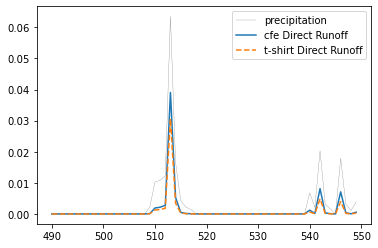

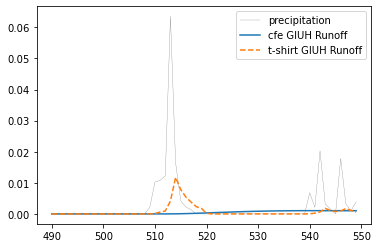

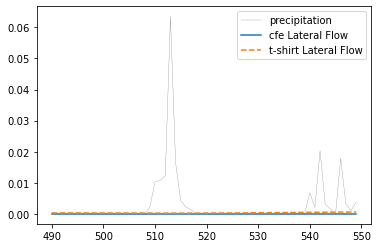

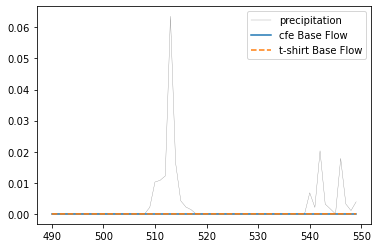

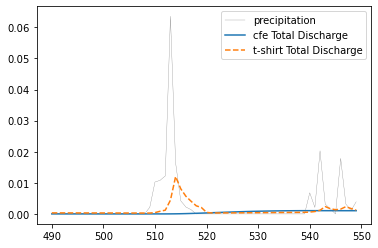

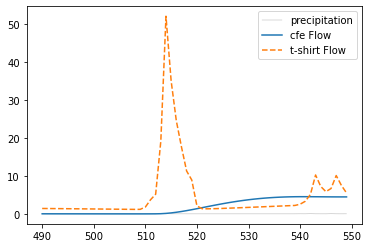

In [27]:
cfe1.run_unit_test()

In [6]:
# BMI FUNCTIONS

In [7]:
cfe1.initialize()

In [8]:
cfe1.update()

In [9]:
cfe1.update_until(700)

total discharge: 3.6465994369865493
at time: 2015-12-01 02:00:00
total discharge: 4.102229843748332
at time: 2015-12-01 03:00:00
total discharge: 4.559747287798911
at time: 2015-12-01 04:00:00
total discharge: 5.012789333605088
at time: 2015-12-01 05:00:00
total discharge: 5.45623177689497
at time: 2015-12-01 06:00:00
total discharge: 5.885657166765029
at time: 2015-12-01 07:00:00
total discharge: 6.297608324000342
at time: 2015-12-01 08:00:00
total discharge: 6.6894080170203125
at time: 2015-12-01 09:00:00
total discharge: 7.059099279016517
at time: 2015-12-01 10:00:00
total discharge: 7.405321716084533
at time: 2015-12-01 11:00:00
total discharge: 7.72726691438264
at time: 2015-12-01 12:00:00
total discharge: 8.024586793692812
at time: 2015-12-01 13:00:00
total discharge: 8.297339195831878
at time: 2015-12-01 14:00:00
total discharge: 8.545913552515291
at time: 2015-12-01 15:00:00
total discharge: 8.770980321192958
at time: 2015-12-01 16:00:00
total discharge: 8.973436829069874
at ti

In [10]:
cfe1.finalize()


GLOBAL MASS BALANCE
  initial volume:  0.595626
    volume input:  2.188132
   volume output:  1.794767
    final volume:  1.084379
        residual: -9.538760e-02

SCHAAKE MASS BALANCE
  surface runoff:   1.8958
    infiltration:   0.2924
schaake residual: -1.8929e-14

GIUH MASS BALANCE
  vol. into giuh:  1.8957583949021923
   vol. out giuh:  1.7947665637561778
 vol. end giuh q:  0.1963794277935013
   giuh residual:  -0.09538759664748678

SOIL WATER CONCEPTUAL RESERVOIR MASS BALANCE
   init soil vol:   0.5856
  vol. into soil:   0.2924
vol.soil2latflow:   0.0000
 vol. soil to gw:   0.0000
 final vol. soil:   0.8780
vol. soil resid.: 3.0087e-14

NASH CASCADE CONCEPTUAL RESERVOIR MASS BALANCE
    vol. to nash:   0.0000
  vol. from nash:   0.0000
 final vol. nash:   0.0000
nash casc resid.: 0.0000e+00

GROUNDWATER CONCEPTUAL RESERVOIR MASS BALANCE
init gw. storage:   0.0100
       vol to gw:   0.0000
     vol from gw:   0.0000
final gw.storage:   0.0100
    gw. residual: 0.0000e+00


In [ ]:
for i in range(1000):
    cfe1.timestep_rainfall_input_m = 0.0
    cfe1.run_cfe()

In [ ]:
cfe1.run_cfe()

In [ ]:
cfe1.total_discharge

In [ ]:
cfe1.current_time_step

In [ ]:
cfe1.current_time

In [ ]:
cfe1.finalize()

In [ ]:
cfe1.initialize()

In [ ]:
cfe1.current_time_step

In [ ]:
cfe1.current_time

In [ ]:
cfe1.update_until(70)